# Delta Omicron multidms data fit

## Import `Python` modules

In [1]:
import os
import math
import pandas as pd
import re
import json
import binarymap as bmap
import matplotlib.pyplot as plt
import seaborn as sns
import jax
jax.config.update("jax_enable_x64", True)
import jax.numpy as jnp
from jax.experimental import sparse
from jaxopt import ProximalGradient
import jaxopt
import numpy as onp
from scipy.stats import pearsonr

from timeit import default_timer as timer
%matplotlib inline

import sys
sys.path.append("..")
from multidms.utils import create_homolog_modeling_data, initialize_model_params
from multidms.model import ϕ, g, prox, cost_smooth

## Read in metadata on homolog DMS experiments

Our primary goal is to get a single dataframe that contains all homolog variants encoded with sequencial sites wrt the wt seqences which have been aligned with no gaps - as well as their functional scores. This can then be converted into our model fitting data.

We'll start by collecting all the data for each homolog into a single dataframe containing all experiments
along with a column holding a nested dataframe for all the associated functional scores.

Additionally, we make a dictionary for the homolog wildtype sequences, and a df for the site maps of both sequences

In [2]:
func_score_data = pd.DataFrame()
sites = {}
wt_seqs = {}

for homolog in ["Delta", "Omicron_BA.1"]:
    
    # functional scores
    func_sel = pd.read_csv(f"../results/{homolog}/functional_selections.csv")
    func_sel = func_sel.assign(
        filename = f"../results/{homolog}/" + 
        func_sel.library + "_" + 
        func_sel.preselection_sample + 
        "_vs_" + func_sel.postselection_sample + 
        "_func_scores.csv"
    )
    func_sel = func_sel.assign(
        func_sel_scores_df = func_sel.filename.apply(lambda f: pd.read_csv(f))
    )
    func_sel = func_sel.assign(
        len_func_sel_scores_df = func_sel.func_sel_scores_df.apply(lambda x: len(x))
    )
    fun_sel = func_sel.assign(homolog = homolog)
    func_score_data = pd.concat([func_score_data, fun_sel])
    
    # WT Protein sequence
    with open(f"../results/{homolog}/protein.fasta", "r") as seq_file:
        header = seq_file.readline()
        wt_seqs[homolog] = seq_file.readline().strip()

    # Sites
    sites[homolog] = (
        pd.read_csv(f"../results/{homolog}/site_numbering_map.csv")
        .rename({"sequential_site":f"{homolog}_site", "sequential_wt":f"{homolog}_wt"})
        .set_index(["reference_site"])
    )

# Add a column that gives a unique ID to each homolog/DMS experiment
func_score_data['homolog_exp'] = func_score_data.apply(
    lambda row: f"{row['homolog']}-{row['library']}-{row['replicate']}".replace('-Lib',''),
    axis=1
)
    
# Show the dataframe summarizing all experiments
func_score_data

,preselection_sample,library,virus_batch,replicate,postselection_sample,preselection_library_sample,postselection_library_sample,selection_name,filename,func_sel_scores_df,len_func_sel_scores_df,homolog,homolog_exp
0,2021-10-28_thaw-1_VSVG_control_1,Lib-1,thaw-1,1,2021-12-14_thaw-1_no-antibody_control_1,Lib-1_2021-10-28_thaw-1_VSVG_control_1,Lib-1_2021-12-14_thaw-1_no-antibody_control_1,Lib-1_2021-10-28_thaw-1_VSVG_control_1_vs_2021...,../results/Delta/Lib-1_2021-10-28_thaw-1_VSVG_...,library pre_sampl...,45131,Delta,Delta-1-1
1,2021-10-28_thaw-1_VSVG_control_2,Lib-1,thaw-1,2,2021-12-14_thaw-1_no-antibody_control_2,Lib-1_2021-10-28_thaw-1_VSVG_control_2,Lib-1_2021-12-14_thaw-1_no-antibody_control_2,Lib-1_2021-10-28_thaw-1_VSVG_control_2_vs_2021...,../results/Delta/Lib-1_2021-10-28_thaw-1_VSVG_...,library pre_sampl...,45131,Delta,Delta-1-2
2,2021-10-28_thaw-1_VSVG_control_1,Lib-3,thaw-1,1,2021-12-14_thaw-1_no-antibody_control_1,Lib-3_2021-10-28_thaw-1_VSVG_control_1,Lib-3_2021-12-14_thaw-1_no-antibody_control_1,Lib-3_2021-10-28_thaw-1_VSVG_control_1_vs_2021...,../results/Delta/Lib-3_2021-10-28_thaw-1_VSVG_...,library pre_sampl...,37703,Delta,Delta-3-1
3,2021-10-28_thaw-1_VSVG_control_2,Lib-3,thaw-1,2,2021-12-14_thaw-1_no-antibody_control_2,Lib-3_2021-10-28_thaw-1_VSVG_control_2,Lib-3_2021-12-14_thaw-1_no-antibody_control_2,Lib-3_2021-10-28_thaw-1_VSVG_control_2_vs_2021...,../results/Delta/Lib-3_2021-10-28_thaw-1_VSVG_...,library pre_sampl...,37703,Delta,Delta-3-2
4,2021-10-28_thaw-1_VSVG_control_1,Lib-4,thaw-1,1,2021-12-14_thaw-1_no-antibody_control_1,Lib-4_2021-10-28_thaw-1_VSVG_control_1,Lib-4_2021-12-14_thaw-1_no-antibody_control_1,Lib-4_2021-10-28_thaw-1_VSVG_control_1_vs_2021...,../results/Delta/Lib-4_2021-10-28_thaw-1_VSVG_...,library pre_sampl...,39694,Delta,Delta-4-1
5,2021-10-28_thaw-1_VSVG_control_2,Lib-4,thaw-1,2,2021-12-14_thaw-1_no-antibody_control_2,Lib-4_2021-10-28_thaw-1_VSVG_control_2,Lib-4_2021-12-14_thaw-1_no-antibody_control_2,Lib-4_2021-10-28_thaw-1_VSVG_control_2_vs_2021...,../results/Delta/Lib-4_2021-10-28_thaw-1_VSVG_...,library pre_sampl...,39694,Delta,Delta-4-2
6,2021-10-28_thaw-1_VSVG_control_1,Lib-2,thaw-1,1,2021-11-28_thaw-1_no-antibody_control_1,Lib-2_2021-10-28_thaw-1_VSVG_control_1,Lib-2_2021-11-28_thaw-1_no-antibody_control_1,Lib-2_2021-10-28_thaw-1_VSVG_control_1_vs_2021...,../results/Delta/Lib-2_2021-10-28_thaw-1_VSVG_...,library pre_sampl...,41586,Delta,Delta-2-1
7,2021-10-28_thaw-1_VSVG_control_2,Lib-2,thaw-1,2,2021-11-28_thaw-1_no-antibody_control_2,Lib-2_2021-10-28_thaw-1_VSVG_control_2,Lib-2_2021-11-28_thaw-1_no-antibody_control_2,Lib-2_2021-10-28_thaw-1_VSVG_control_2_vs_2021...,../results/Delta/Lib-2_2021-10-28_thaw-1_VSVG_...,library pre_sampl...,41586,Delta,Delta-2-2
0,2022-03-25_thaw-1_VSVG_control_1,Lib-1,thaw-1,1,2022-04-13_thaw-1_no-antibody_control_1,Lib-1_2022-03-25_thaw-1_VSVG_control_1,Lib-1_2022-04-13_thaw-1_no-antibody_control_1,Lib-1_2022-03-25_thaw-1_VSVG_control_1_vs_2022...,../results/Omicron_BA.1/Lib-1_2022-03-25_thaw-...,library pre_sampl...,94347,Omicron_BA.1,Omicron_BA.1-1-1
1,2022-03-25_thaw-1_VSVG_control_2,Lib-1,thaw-1,2,2022-04-13_thaw-1_no-antibody_control_2,Lib-1_2022-03-25_thaw-1_VSVG_control_2,Lib-1_2022-04-13_thaw-1_no-antibody_control_2,Lib-1_2022-03-25_thaw-1_VSVG_control_2_vs_2022...,../results/Omicron_BA.1/Lib-1_2022-03-25_thaw-...,library pre_sampl...,94347,Omicron_BA.1,Omicron_BA.1-1-2


Make a list of sites that are present in one homolog, but not the other.

In [3]:
set.symmetric_difference(
    set(sites["Delta"].reset_index()["reference_site"].values.astype(str)), 
    set(sites["Omicron_BA.1"].reset_index()["reference_site"].values.astype(str))
)

{'143', '144', '145', '157', '158', '211', '214a', '214b', '214c', '69', '70'}

## Get functional scores for experiments to be compared

Define input variables

In [243]:
# Define which homologs to compare
homolog_column = 'homolog_exp'
homolog_1 = 'Delta-3-1' # 'Omicron_BA.1-2-1' #  
homolog_2 = 'Delta-3-2' # 'Omicron_BA.1-3-1' # 
reference_homolog = homolog_1

# Other input variables
subs_col = "aa_substitutions_reference"
func_score_col = "func_score"
shift_func_scores = False
shift_func_scores_nonref = -1.5
clip_y = None # [-5,2.5] # 

subset_data = None
agg_variants = True
min_pre_counts = 100

Make a single dataframe with functional scores from both homologs being compared, and curate the data.

In [244]:
# Get the data for each homolog to compare
dfs = []
for (i, row) in func_score_data.iterrows():
    homolog = row[homolog_column]
    if homolog in [homolog_1, homolog_2]:
        homolog_df = row['func_sel_scores_df'].copy()
        homolog_df[homolog_column] = homolog
        if (shift_func_scores) and (homolog == homolog_2):
            print(f'Shifting functional scores for {homolog}')
            homolog_df[func_score_col] += shift_func_scores_nonref
        dfs.append(homolog_df)
func_score_df = pd.concat(dfs)
func_score_df.reset_index(drop=True, inplace=True)

# Drop variants with mutations to gaps, and variants that have
# a stop codon as the wildtype (occur at position 1253 due to
# renumbering)
func_score_df.aa_substitutions_reference.fillna("", inplace=True)
gapped_sub_vars = [idx for idx, row in func_score_df.iterrows() if "-" in row.aa_substitutions_reference]
stop_wt_vars = []
for idx, row in func_score_df.iterrows():
    for sub in row[subs_col].split():
        if sub[0] == "*":
            stop_wt_vars.append(idx)
to_drop = set.union(set(gapped_sub_vars), set(stop_wt_vars))
func_score_df.drop(to_drop, inplace=True)

# Drop barcoded variants with pre-counts below a threshold
n_pre_threshold = len(func_score_df)
func_score_df = func_score_df[func_score_df['pre_count'] >= min_pre_counts]
print(f'Of {n_pre_threshold} variants, {n_pre_threshold - len(func_score_df)} had fewer than {min_pre_counts} counts before selection, and were filtered out')

# Remove 214a/b/c sites since they cause problems below
# TODO: fix this?
func_score_df = func_score_df[
    ~(func_score_df[subs_col].str.contains('E214a')) &
    ~(func_score_df[subs_col].str.contains('P214b')) &
    ~(func_score_df[subs_col].str.contains('E214c'))
]

# If indicated, clip y values
if clip_y:
    print('Clipping functional scores to a min and max of: ', clip_y)
    func_score_df[func_score_col].clip(*clip_y, inplace=True)

Of 70618 variants, 5400 had fewer than 100 counts before selection, and were filtered out


Plot the distribution of functional scores

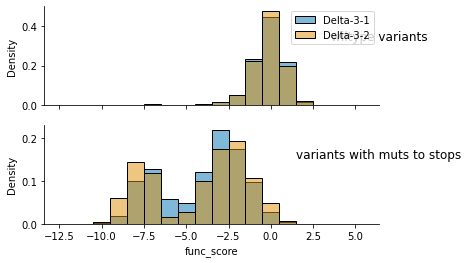

In [245]:
# Initialize a list of dataframes to plot
data_to_plot = []

# Get data for wildtype variants
data = func_score_df[func_score_df[subs_col] == ''].copy()
data_to_plot.append(('wiltype variants', data))

# Get data for variants with stop codons
data = func_score_df[
    func_score_df[subs_col].str.contains('\*')
].copy()
data_to_plot.append(('variants with muts to stops', data))

# Pre-determine bins
min_val = -12 # math.floor(func_score_df[func_score_col].min())
max_val = 5 # math.ceil(func_score_df[func_score_col].max())
bin_size = 1
bins = onp.arange(min_val - bin_size/2, max_val + bin_size, bin_size)

# Plot data
(fig, axs) = plt.subplots(nrows=2, sharex=True)
pal = sns.color_palette('colorblind')
for (i, (title, data)) in enumerate(data_to_plot):
    for (c_i, (h, data_h)) in enumerate(data.groupby(homolog_column)):
        sns.histplot(
            x=func_score_col, data=data_h, bins=bins,
            stat='density', color=pal.as_hex()[c_i], label=h,
            alpha=0.5, ax=axs[i]
        )
    axs[i].set_title(title, x=1, y=0.6)
axs[0].legend()
sns.despine()
plt.show()

For variants with stop codons, does the functional score correlate with the position of the stop codon in the gene? Or number of pre counts?

Showing data for homolog: Delta-3-1
Clipping pre-counts to a max of 1000


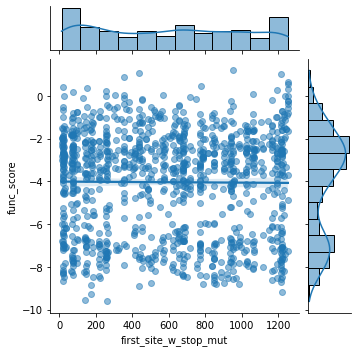

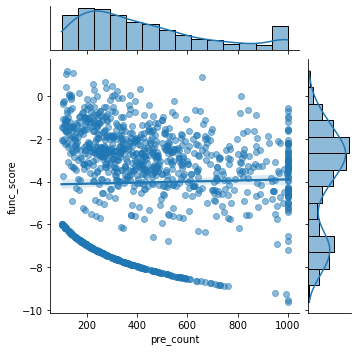

In [246]:
# Get data for variants with stop codons
homolog = reference_homolog # 'Omicron_BA.1-2-1' # 'Delta'
print(f'Showing data for homolog: {homolog}')
data = func_score_df[
    (func_score_df[homolog_column] == homolog) &
    (func_score_df[subs_col].str.contains('\*'))
].copy()

# Identify the first site in a variant to have a stop-
# codon mutation
def get_first_site_with_stop_mut(sub_str):
    sites = []
    for sub in sub_str.split():
        if sub[-1] == '*':
            sites.append(int(sub[1:-1]))
    return sorted(sites)[0]
data['first_site_w_stop_mut'] = data[subs_col].apply(
    lambda x: get_first_site_with_stop_mut(x)
)

# Clip upper bound of pre-counts
max_pre_count = 1000
print(f'Clipping pre-counts to a max of {max_pre_count}')
data['pre_count'].clip(upper=max_pre_count, inplace=True)

# Plot data
metrics = ['first_site_w_stop_mut', 'pre_count']
for metric in metrics:
    sns.jointplot(
        x=metric, y=func_score_col,
        data=data, kind='reg', height=5,
        joint_kws = {'scatter_kws':dict(alpha=0.5)}
    )
    sns.despine()
    plt.show()

In [247]:
data[
    (data['pre_count'].between(200,400)) &
    (data[func_score_col].between(-8,-6))
][[
    'barcode', func_score_col,
    'pre_count', 'post_count',
    'pre_count_wt', 'post_count_wt',
    subs_col
]].head(n=5)

,barcode,func_score,pre_count,post_count,pre_count_wt,post_count_wt,aa_substitutions_reference
19072,TGATACTAAAAAAAAC,-7.9569,400,0,1154203,358015,A570T C649R Q836* N1178Y
19250,CGAAATAACCTTCTGC,-7.9424,396,0,1154203,358015,L849I Q1036* E1188D M1237T
19582,CGACAGATGAAATTCT,-7.9167,389,0,1154203,358015,S255* N439A V1068M
19637,TGCCACTTTATACGTG,-7.9130,388,0,1154203,358015,G75W D215K W353*
19790,ACTACTATACCCAAGG,-7.8980,384,0,1154203,358015,D142S W1212* G1219A


Look at the correlation in functional score between homologs (only really works if the "homologs" are replicate experiments of the same library).

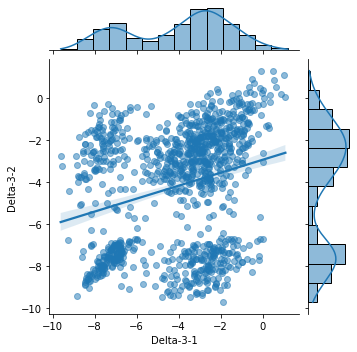

In [248]:
data = func_score_df[
    #(func_score_df['pre_count'] > 100) &
    #(func_score_df['post_count'] > 5) &
    (func_score_df[subs_col].str.contains('\*'))
].copy()
data = pd.pivot_table(
    data, index=subs_col,
    values=func_score_col,
    columns=homolog_column
)
sns.jointplot(
    x=homolog_1, y=homolog_2,
    data=data, kind='reg', height=5,
    joint_kws = {'scatter_kws':dict(alpha=0.5)}
)
plt.show()

**What does the above plot indicate about the source of noise / the cause of the bimodal distribution?**

Before fitting models, option to subset the data, or aggregate data among barcodes that encode the same variant.

In [218]:
if subset_data:
    func_score_df = func_score_df.sample(n=subset_data, random_state=23).reset_index()
if agg_variants:
    func_score_df = func_score_df.groupby([subs_col, homolog_column]).mean().reset_index()
    func_score_df["pre_count"] = func_score_df["pre_count"].astype(int)
    func_score_df["post_count"] = func_score_df["post_count"].astype(int)    

Option to subset the data to just the reference homolog.

In [219]:
if False:
    func_score_df = func_score_df[
        (func_score_df[homolog_column] == reference_homolog)
    ]

Create a new dataframe in which mutations are all relative to the reference homolog.

In [220]:
(X, y), df, all_subs, site_map = create_homolog_modeling_data(
                            func_score_df, 
                            homolog_column,
                            reference_homolog,
                            subs_col,
                            func_score_col
                        )

Found 0 site(s) lacking data in at least one homolog.
0 of the 130148 variants were removed because they had mutations at the above sites, leaving 130148 variants.


100%|██████████████████████████████████████████████████████████████████| 60995/60995 [03:08<00:00, 323.45it/s]


In [221]:
print('Number of datapoints per homolog:')
for (homolog, data) in df.groupby(homolog_column):
    print(homolog, len(data))

Number of datapoints per homolog:
Omicron_BA.1-2-1 69153
Omicron_BA.1-3-1 60995


Fit models

In [222]:
# Params for fitting
maxiter = 2000
λ_ridge = 1e-5
clip_str = "-".join([str(c) for c in clip_y]) if clip_y else clip_y
fig_saveas_prefix = (f"tar-{func_score_col}-clipy-{clip_str}"
                    f"-ref-{reference_homolog}"
                    f"-agg-{agg_variants}"
                    f"-sub-{subset_data}"
                    f"-iter-{maxiter}-λ_ridge-{λ_ridge}")

# Initialize the range and minimum of the sigmoid
# from the global epistasis function using the 5th
# and 95th percentile values from the raw data
sig_upper = df[func_score_col].quantile(0.95)
sig_lower = df[func_score_col].quantile(0.05)
sig_range = sig_upper - sig_lower

# Initialize all params
params = initialize_model_params(
    func_score_df[homolog_column].unique(), 
    n_beta_shift_params=X[reference_homolog].shape[1],
    include_alpha=True,
    init_sig_range=sig_range,
    init_sig_min=sig_lower
)

In [223]:
print(f"\nPre-Optimization")
print(f"----------------")
print(f"cost = {cost_smooth(params, (X, y), λ_ridge=0):.2e}")


Pre-Optimization
----------------
cost = 4.01e+00


In [224]:
tol = 1e-6
maxiter = maxiter
start = timer()

solver = ProximalGradient(cost_smooth, prox, tol=tol, maxiter=maxiter)

# First, just fit data on reference homolog
# params, state = solver.run(
#     params, 
#     hyperparams_prox = dict(
#         clip_stretch=0.0, 
#         lock_params= {
#             f"S_{reference_homolog}" : jnp.zeros(len(params['β'])),
#             f"C_{reference_homolog}" : jnp.zeros(shape=(1,)),
#             f"C_{homolog_2}" : jnp.zeros(shape=(1,))
#         }
#     ),
#     data=(
#         {reference_homolog : X[reference_homolog]},
#         {reference_homolog : y[reference_homolog]}
#     ),
#     λ_ridge=0
# )

# Next, jointly fit data on both homologs
params, state = solver.run(
    params, 
    hyperparams_prox = dict(
        clip_stretch=0.0, 
        lock_params= {
            f"S_{reference_homolog}" : jnp.zeros(len(params['β'])),
            f"C_{reference_homolog}" : jnp.zeros(shape=(1,)),
            f"C_{homolog_2}" : jnp.zeros(shape=(1,))
        }
    ),
    data=(X, y),
    λ_ridge=λ_ridge
)
end = timer()

print(f"\nPost-Optimization")
print(f"-----------------")
print(f"Full model optimization: {state.iter_num} iterations")
print(f"error = {state.error:.2e}")
print(f"cost = {cost_smooth(params, (X, y)):.2e}")
print(f"Wall time for fit: {end - start}")


Post-Optimization
-----------------
Full model optimization: 2000 iterations
error = 1.32e-03
cost = 5.94e-01
Wall time for fit: 33.03983556799358


Print summary stats of fit params

In [225]:
for param in ["β", f"S_{reference_homolog}", f"S_{homolog_2}"]:
    print(f"\nFit {param} distribution\n===============")
    if param not in params:
        continue
    arr = onp.array(params[param])
    mean = onp.mean(arr)
    median = onp.median(arr)
     
    # measures of dispersion
    min = onp.amin(arr)
    max = onp.amax(arr)
    range = onp.ptp(arr)
    variance = onp.var(arr)
    sd = onp.std(arr)
     
    print("Descriptive analysis")
    print("Measures of Central Tendency")
    print(f"Mean = {mean:.2e}")
    print(f"Median = {median:.2e}")
    print("Measures of Dispersion")
    print(f"Minimum = {min:.2e}")
    print(f"Maximum = {max:.2e}")
    print(f"Range = {range:.2e}")
    print(f"Variance = {variance:.2e}")
    print(f"Standard Deviation = {sd:.2e}")
    
if f'C_{homolog_2}' in params:
    print(f"\nC_{homolog_2}: {params[f'C_{homolog_2}']}")

print(f"\nFit Sigmoid Parameters, α\n================")
for param, value in params['α'].items():
    print(f"{param}: {value}") 

df["predicted_latent_phenotype"] = onp.nan
df[f"predicted_{func_score_col}"] = onp.nan

print(f"\nRunning Predictions")
print(f"-------------------")
for homolog, hdf in df.groupby(homolog_column):
    h_params = {"β":params["β"], "S":params[f"S_{homolog}"], "C":params[f"C_{homolog}"]}
    z_h = ϕ(h_params, X[homolog])
    df.loc[hdf.index, "predicted_latent_phenotype"] = z_h
    y_h_pred = g(params["α"], z_h)
    df.loc[hdf.index, f"predicted_{func_score_col}"] = y_h_pred

print(f"Done")


Fit β distribution
Descriptive analysis
Measures of Central Tendency
Mean = -1.59e+00
Median = -6.41e-01
Measures of Dispersion
Minimum = -1.07e+01
Maximum = 4.71e+00
Range = 1.54e+01
Variance = 5.19e+00
Standard Deviation = 2.28e+00

Fit S_Omicron_BA.1-2-1 distribution
Descriptive analysis
Measures of Central Tendency
Mean = 0.00e+00
Median = 0.00e+00
Measures of Dispersion
Minimum = 0.00e+00
Maximum = 0.00e+00
Range = 0.00e+00
Variance = 0.00e+00
Standard Deviation = 0.00e+00

Fit S_Omicron_BA.1-3-1 distribution
Descriptive analysis
Measures of Central Tendency
Mean = -1.43e-02
Median = 0.00e+00
Measures of Dispersion
Minimum = -2.01e+00
Maximum = 1.33e+00
Range = 3.34e+00
Variance = 1.02e-01
Standard Deviation = 3.20e-01

C_Omicron_BA.1-3-1: [0.]

Fit Sigmoid Parameters, α
ge_bias: [-4.70696632]
ge_scale: [5.6855339]
latent_bias: [1.55137858]

Running Predictions
-------------------
Done


Plot the distribution of beta and shift parameters.

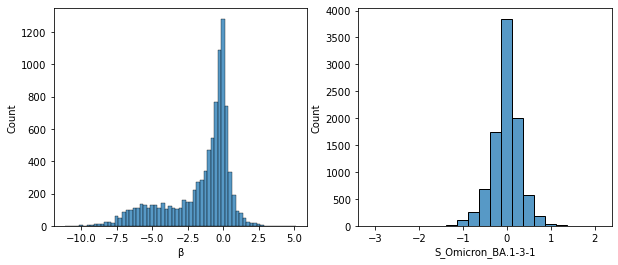

In [226]:
params_to_plot = ["β", f"S_{homolog_2}"]
fig, ax = plt.subplots(1,2, figsize=[10, 4])
for i, param in enumerate(params_to_plot):
    if param in params:
        bin_width = 0.25
        min_val = math.floor(params[param].min()) - 0.25/2
        max_val = math.ceil(params[param].max())
        sns.histplot(
            params[param], ax=ax[i],
            binwidth=bin_width, binrange=(min_val, max_val)
        )
        ax[i].set(xlabel=param)
plt.show()
fig.savefig(f"{fig_saveas_prefix}-beta-shift-hist.png")

Plot predicted vs. observed values

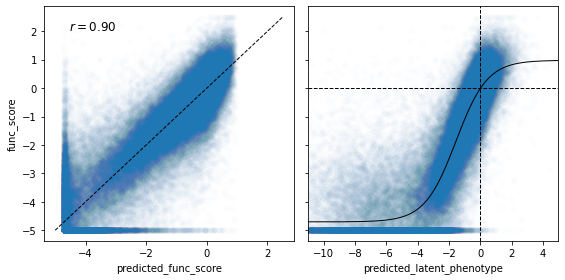

In [227]:
fig, ax = plt.subplots(1, 2, figsize=[8, 4], sharey=True)
sns.scatterplot(
    data=df, x=f"predicted_{func_score_col}",
    y=func_score_col,
    #hue=homolog_column,
    alpha=0.01, palette="deep", ax=ax[0],
    legend=True
)

lb = df[[func_score_col, f"predicted_{func_score_col}"]].min().min()
ub = df[[func_score_col, f"predicted_{func_score_col}"]].max().max()

ax[0].plot([lb, ub], [lb, ub], "k--", lw=1)
r = pearsonr(df[func_score_col], df[f'predicted_{func_score_col}'])[0]
ax[0].annotate(f"$r = {r:.2f}$", (.1, .9), xycoords="axes fraction", fontsize=12)

# shape 
sns.scatterplot(
    data=df, x="predicted_latent_phenotype",
    y=func_score_col,
    #hue=homolog_column,
    alpha=0.01, palette="deep",
    legend=True, ax=ax[1]
)

ϕ_grid = onp.linspace(
    1.1 * df.predicted_latent_phenotype.min(),
    1.1 * df.predicted_latent_phenotype.max(),
    num=1000
)
shape = (ϕ_grid, g(params["α"], ϕ_grid))
ax[1].plot(*shape, color='k', lw=1)
#ax[1].set_ylim(-11, 1)
ax[1].set_xlim(-11, 5)
plt.axhline(0, color="k", ls="--", lw=1)
plt.axvline(0, color="k", ls="--", lw=1)
fig.savefig(f"{fig_saveas_prefix}-scatter.png")
plt.tight_layout()
#sns.despine()
plt.show()

**Observations**
* For jointly fitting delta/omicron data, the sigmoid often maxes out below 0. Could this be because extreme outliers are dragging it down? Is there a better loss function that would help resolve this?

Plot the distribution of betas and shift parameters.

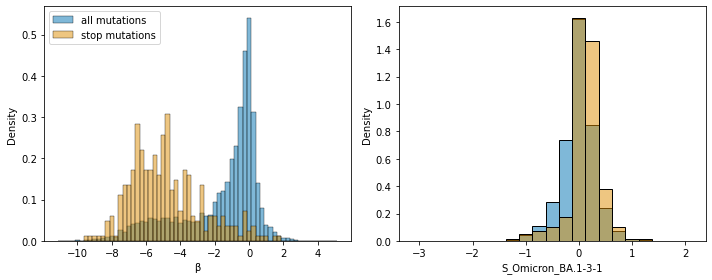

In [241]:
# Make a dataframe with inferred mutational effects
def split_sub(sub_string):
    """String match the wt, site, and sub aa
    in a given string denoting a single substitution"""

    pattern = r'(?P<aawt>[A-Z\*])(?P<site>[\d\w]+)(?P<aamut>[A-Z\*])'
    match = re.search(pattern, sub_string)
    assert match != None, sub_string
    return match.group('aawt'), match.group('site'), match.group('aamut')

mut_effects_dict = {
    key : []
    for key in ['wt', 'site', 'mut', 'param', 'param_val']
}
for (i, param) in enumerate(["β", f"S_{homolog_2}"]):
    if param in params:
        for (mutation, param_val) in zip(all_subs, params[param]):
            (wt, site, mut) = split_sub(mutation)
            mut_effects_dict['wt'].append(wt)
            mut_effects_dict['site'].append(int(site))
            mut_effects_dict['mut'].append(mut)
            mut_effects_dict['param'].append(param)
            mut_effects_dict['param_val'].append(float(param_val))
        
mut_effects_df = pd.DataFrame(mut_effects_dict)

(fig, axs) = plt.subplots(ncols=2, figsize=[10,4])
for (i, param) in enumerate(["β", f"S_{homolog_2}"]):
    
    # Plot data for all mutations
    data = mut_effects_df[(mut_effects_df['param'] == param)]
    bin_width = 0.25
    min_val = math.floor(data['param_val'].min()) - 0.25/2
    max_val = math.ceil(data['param_val'].max())
    sns.histplot(
        x='param_val', data=data, ax=axs[i],
        stat='density', color=pal.as_hex()[0],
        label='all mutations',
        binwidth=bin_width, binrange=(min_val, max_val),
        alpha=0.5
    )
    
    # Plot data for mutations leading to stop codons
    data = mut_effects_df[
        (mut_effects_df['mut'] == '*') &
        (mut_effects_df['param'] == param)
    ]
    sns.histplot(
        x='param_val', data=data, ax=axs[i],
        stat='density', color=pal.as_hex()[1],
        label='stop mutations',
        binwidth=bin_width, binrange=(min_val, max_val),
        alpha=0.5
    )
    
    axs[i].set(xlabel=param)

plt.tight_layout()
axs[0].legend()
plt.show()

To do for presenting to Jesse and Bernadeta:
* discuss w/ Jared:
    * differences between w/in homolog comparisons
    * new fitting strategy?
        * fit each homolog independently, then initialize joint fit with betas of reference?
        * come up w/ way to make datasets comparable
        * compare position of wt on sigmoid
        * add param to shift functional scores in non-reference homolog (could do this based on difference of wt on sigmoid?)
    * change loss function to be less sensitive to outliers? And to force sigmoid to go through the origin?

* updates for Jared
    * wildtype for omicron was getting filtered out! Due to indices being duplicated in many cases
    
* Question for 

In [ ]:
%matplotlib inline

fig, ax = plt.subplots(2, figsize=(25, 10))

# non_identical_sites = [
#     i for i, row in site_map.iterrows()
#     if row["Delta"] != row["Omicron_BA.1"]
# ]

def split_sub(sub_string):
    """String match the wt, site, and sub aa
    in a given string denoting a single substitution"""

    pattern = r'(?P<aawt>[A-Z\*])(?P<site>[\d\w]+)(?P<aamut>[A-Z\*])'
    match = re.search(pattern, sub_string)
    assert match != None, sub_string
    return match.group('aawt'), match.group('site'), match.group('aamut')

for i, param in enumerate(["β", "S_Omicron_BA.1"]):
    rows = []
    for mutation, p in zip(all_subs, params[param]):
        wt, site, mut = split_sub(mutation)
        rows.append([int(site), wt, mut, float(p)])
        
    mutation_effects = pd.DataFrame(
        rows,
        columns=("site", "wildtype", "mutant", param)
    ).pivot(
        index="mutant",
        columns="site", values=param
    )#.iloc[:, :100]
    
    sns.heatmap(
        mutation_effects, 
        mask=mutation_effects.isnull(),
        cmap="coolwarm_r",
        center=0,
        cbar_kws={"label": param},
        ax=ax[i]
    )
    ax[i].set_title(f"{param}", size=20)

    
plt.tight_layout()
fig.savefig(f"{fig_saveas_prefix}-heatmap.png")
plt.show()

In [ ]:
# Plot data
# min_val = mut_effects_df['param_val'].min()
# max_val = mut_effects_df['param_val'].max()
# nbins = 20
# bin_size = (max_val - min_val) / nbins
# bins = onp.arange(min_val-bin_size/2, max_val+bin_size, bin_size)
# data = mut_effects_df[(mut_effects_df['mut'] == '*')]
# sns.histplot(x='param_val', data=data, hue='param', bins=bins)
# plt.tight_layout()
# sns.despine()
# plt.show()